In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import association_metrics as am

In [2]:
df=pd.read_csv("C:/Users/rprat/OneDrive/Documents/Haaland Scoring Data.csv")

In [3]:
df

,Date,Day,Comp,Round,Venue,Result,Squad,Opponent,Start,Pos,Min,Gls,Ast,PK,Opp W,Opp D,Opp L,Match Report
0,Mar-23,Sun,Eliteserien,Regular season,Home,W 5–0,Molde,Sandefjord,N,NaN,25,0,0,0,0,0,0,Match Report
1,Mar-23,Sun,Eliteserien,Regular season,Away,W 1–0,Molde,Haugesund,N,NaN,35,0,0,0,1,0,0,Match Report
2,Apr-23,Sun,Eliteserien,Regular season,Away,L 0–4,Molde,Rosenborg,N,NaN,36,0,0,0,0,2,1,Match Report
3,Apr-23,Sun,Eliteserien,Regular season,Home,W 2–1,Molde,Lillestrøm,Y,FW,90,1,0,1,1,1,2,Match Report
4,Apr-23,Sun,Eliteserien,Regular season,Away,D 0–0,Molde,Vålerenga,Y,FW,82,0,0,0,3,0,2,Match Report
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,Sep-23,Sat,Premier League,Regular season,Away,W 3–1,Manchester City,West Ham,Y,FW,89,1,0,0,3,1,0,Match Report
228,Sep-23,Tue,Champions League,Group stage,Home,W 3–1,eng Manchester City,rs Red Star,Y,FW,90,0,1,0,0,0,0,Match Report
229,Sep-23,Sat,Premier League,Regular season,Home,W 2–0,Manchester City,Nott'ham Forest,Y,FW,90,1,0,0,2,1,2,Match Report
230,Sep-23,Sat,Premier League,Regular season,Away,L 1–2,Manchester City,Wolves,Y,FW,90,0,0,0,2,1,3,Match Report


## Part I: Data Cleaning

### Step 1: Reformat data

In [4]:
df["Date"]=df["Date"].str[:-3]

In [5]:
for i in df["Comp"]:
    if i in ["Eliteserien", "Premier League", "Austrian Bundesliga", "Bundesliga"]:
        df["Comp"]=df["Comp"].replace(i, "Domestic League")    
    elif i in ["Community Shield", "DFB-Pokal","EFL Cup", "DFL-Supercup", "FA Cup"]:
        df["Comp"]=df["Comp"].replace(i, "Domestic Cup")    
    elif i in ["Champions League", "Europa League", "UEFA Super Cup"]:
        df["Comp"]=df["Comp"].replace(i, "European Club Competition")

In [6]:
df["Competition"]=df["Comp"]+" "+df["Round"]

In [7]:
df["Opponent Form"]=df["Opp W"]-df["Opp L"]+df["Opp D"]*0.5
df["Opponent Form"]=df["Opponent Form"].astype(float)

In [8]:
df["Competition"]=df["Competition"].replace("International Friendly International Friendly", "International Friendly")

In [9]:
df["Score?"]=np.where(df["Gls"]>0, "Scored", "Didn't Score")

In [10]:
df.drop(columns=["Comp", "Round", "Result","Squad","Opponent","Pos","Min","Gls","Ast","PK","Opp W", "Opp D", "Opp L", "Match Report"], inplace=True)

In [11]:
df

,Date,Day,Venue,Start,Competition,Opponent Form,Score?
0,Mar,Sun,Home,N,Domestic League Regular season,0.0,Didn't Score
1,Mar,Sun,Away,N,Domestic League Regular season,1.0,Didn't Score
2,Apr,Sun,Away,N,Domestic League Regular season,0.0,Didn't Score
3,Apr,Sun,Home,Y,Domestic League Regular season,-0.5,Scored
4,Apr,Sun,Away,Y,Domestic League Regular season,1.0,Didn't Score
...,...,...,...,...,...,...,...
227,Sep,Sat,Away,Y,Domestic League Regular season,3.5,Scored
228,Sep,Tue,Home,Y,European Club Competition Group stage,0.0,Didn't Score
229,Sep,Sat,Home,Y,Domestic League Regular season,0.5,Scored
230,Sep,Sat,Away,Y,Domestic League Regular season,-0.5,Didn't Score


## Part II: Data Exploration

In [12]:
games_goal=len(df[(df["Score?"]=="Scored")])
games_nogoal=len(df[(df["Score?"]=="Didn't Score")])

print(f"Haaland has scored in {round((games_goal/(games_nogoal+games_goal))*100)}% of the games he has played in the last 5 years.")

Haaland has scored in 55% of the games he has played in the last 5 years.


### Goals by Competition Type

In [13]:
competitions=list(df["Competition"].unique())
gamescount=[len(df[(df["Competition"]==i)]) for i in competitions]
comp_goal=[len(df[(df["Score?"]=="Scored")&(df["Competition"]==i)]) for i in competitions]
comp_nogoal=[len(df[(df["Score?"]=="Didn't Score")&(df["Competition"]==i)]) for i in competitions]
comp_goalrate=[str(round((comp_goal[i]/(comp_goal[i]+comp_nogoal[i]))*100)) +"% scored" for i in range(len(competitions))]

data={"Competition":competitions,"Games Played": gamescount, "Games Scored":comp_goal,"Game Didn't Score":comp_nogoal,"Scoring Rate":comp_goalrate}

df2=pd.DataFrame(data)
df2=df2.sort_values(by="Games Played", ascending=True)

gamescount=df2["Games Played"].tolist()
competitions=df2["Competition"].tolist()
comp_goal=df2["Games Scored"].tolist()
comp_nogoal=df2["Game Didn't Score"].tolist()
comp_goalrate=df2["Scoring Rate"].tolist()

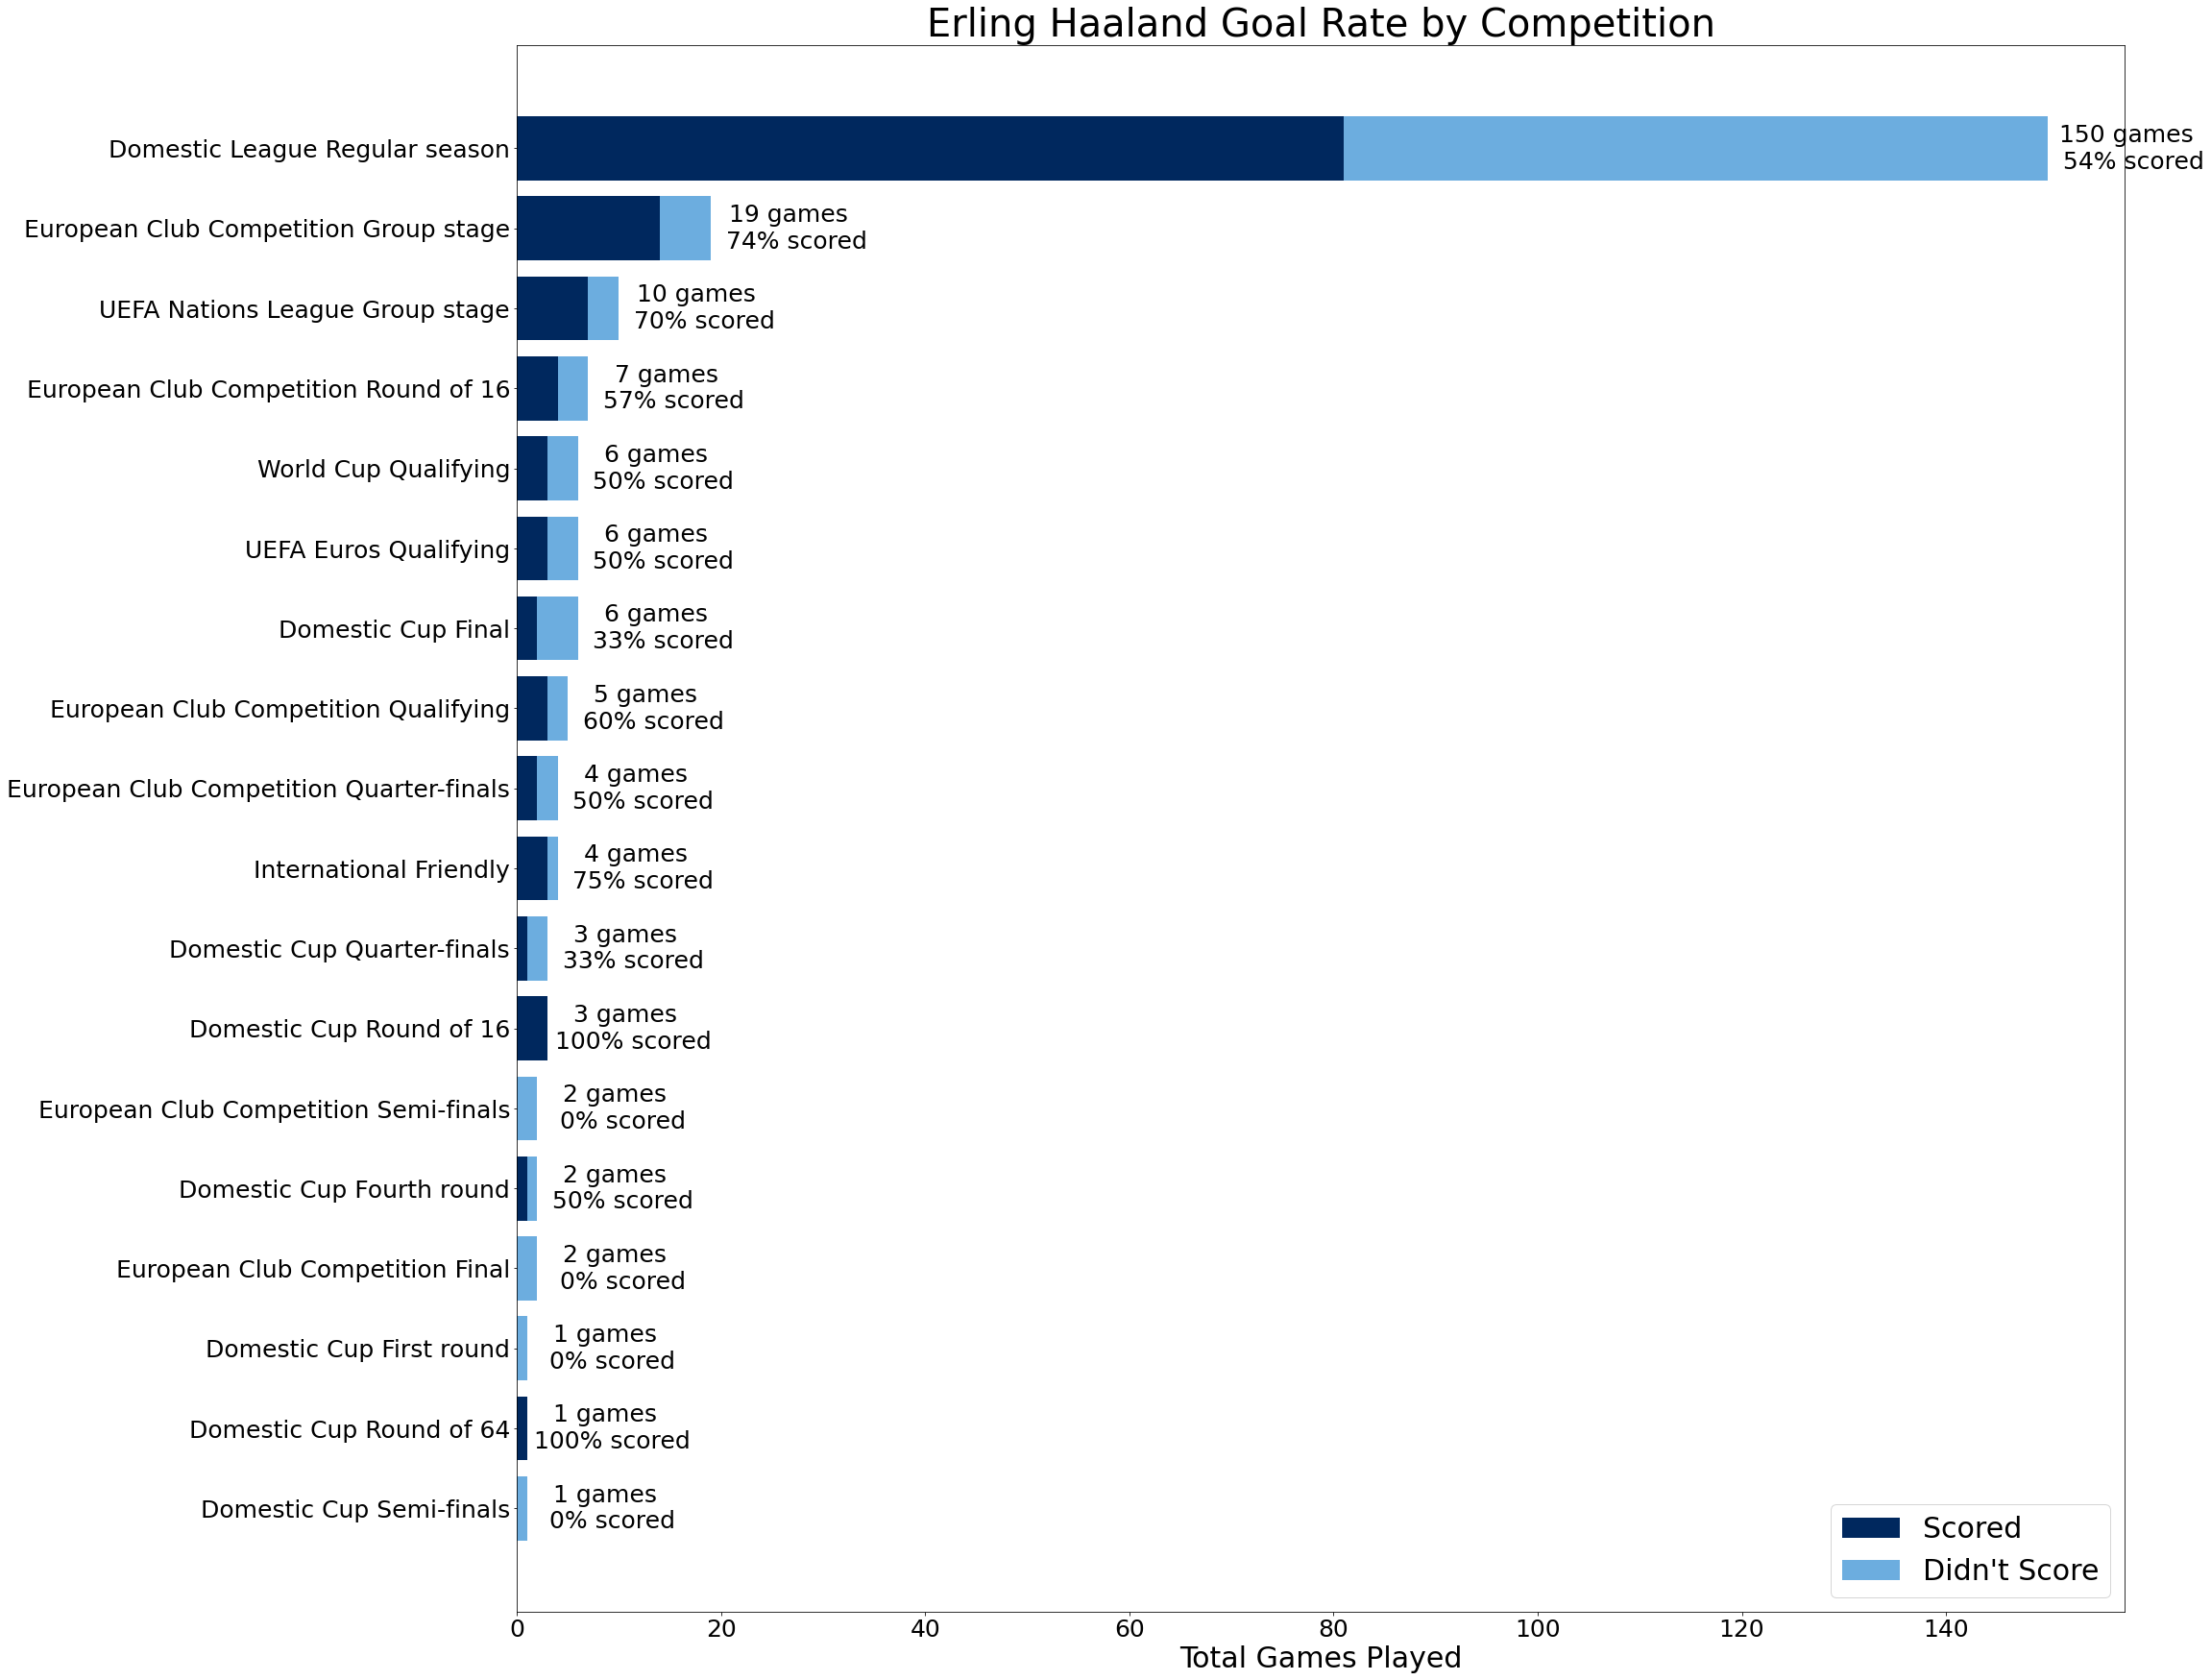

In [14]:
#plt.rcParams['figure.figsize']=[30,25]
fig, ax=plt.subplots(figsize=(30,30))
ax.barh(competitions, comp_goal, color='#00285e')
ax.barh(competitions, comp_nogoal, left=comp_goal, color='#6caddf')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.legend(["Scored","Didn't Score"], fontsize=30, loc= 'lower right')
plt.title("Erling Haaland Goal Rate by Competition", fontsize=40)
plt.xlabel("Total Games Played",fontsize=30)

for i in range(len(comp_goalrate)):
    ax.text(comp_goal[i] + comp_nogoal[i]+8, competitions[i], str(gamescount[i])+ " games \n " +comp_goalrate[i], ha='center', va="center", fontsize=25)

plt.show()

## Part III: Model Development

### Step 1: Prepare Data for Computation

In [15]:
df["Score?"].value_counts()

Scored          128
Didn't Score    104
Name: Score?, dtype: int64

In [16]:
df['Score?'] = df['Score?'].map({'Scored': 1, "Didn't Score": 0})

In [17]:
x=df.drop("Score?",axis=1)
predictors=x
y=df["Score?"]

In [18]:
categorical_features=x[["Date", "Venue", "Start", "Competition"]]
categorical_features

,Date,Venue,Start,Competition
0,Mar,Home,N,Domestic League Regular season
1,Mar,Away,N,Domestic League Regular season
2,Apr,Away,N,Domestic League Regular season
3,Apr,Home,Y,Domestic League Regular season
4,Apr,Away,Y,Domestic League Regular season
...,...,...,...,...
227,Sep,Away,Y,Domestic League Regular season
228,Sep,Home,Y,European Club Competition Group stage
229,Sep,Home,Y,Domestic League Regular season
230,Sep,Away,Y,Domestic League Regular season


In [19]:
encoder=OneHotEncoder(handle_unknown="ignore")

In [20]:
#Encode dates
encoded_df=pd.DataFrame(encoder.fit_transform(x[["Date"]]).toarray())
x=x.join(encoded_df)
x.columns=["Date","Day","Venue", "Start", "Competition","Opponent Form",'Apr','Aug','Dec','Feb','Jan','Jul','Jun','Mar','May','Nov','Oct','Sep']

In [21]:
#Encode days
encoded_df=pd.DataFrame(encoder.fit_transform(x[["Day"]]).toarray())
x=x.join(encoded_df)
x.columns=["Date","Day", "Venue", "Start", "Competition","Opponent Form",'Apr','Aug','Dec','Feb','Jan','Jul','Jun','Mar','May','Nov','Oct','Sep',
          'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

In [22]:
#Encode venues
encoded_df=pd.DataFrame(encoder.fit_transform(x[["Venue"]]).toarray())
x=x.join(encoded_df)
x.columns=["Date","Day","Venue", "Start", "Competition","Opponent Form",'Apr','Aug','Dec','Feb','Jan','Jul','Jun','Mar','May','Nov','Oct','Sep',
          'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed',"Away","Home","Neutral"]

In [23]:
#Encode start
encoded_df=pd.DataFrame(encoder.fit_transform(x[["Start"]]).toarray())
x=x.join(encoded_df)
x.columns=["Date","Day","Venue", "Start", "Competition","Opponent Form",'Apr','Aug','Dec','Feb','Jan','Jul','Jun','Mar','May','Nov','Oct','Sep',
          'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed',"Away","Home","Neutral","N","Y"]

In [24]:
#Encode competitions
encoded_df=pd.DataFrame(encoder.fit_transform(x[["Competition"]]).toarray())
x=x.join(encoded_df)
x.columns=["Date","Day", "Venue", "Start", "Competition","Opponent Form",'Apr','Aug','Dec','Feb','Jan','Jul','Jun','Mar','May','Nov','Oct','Sep',
          'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed',"Away","Home","Neutral","N","Y",'Domestic Cup Final', 'Domestic Cup First round',
          'Domestic Cup Fourth round','Domestic Cup Quarter-finals','Domestic Cup Round of 16','Domestic Cup Round of 64','Domestic Cup Semi-finals',
          'Domestic League Regular season','European Club Competition Final','European Club Competition Group stage','European Club Competition Qualifying',
          'European Club Competition Quarter-finals','European Club Competition Round of 16','European Club Competition Semi-finals',
          'International Friendly', 'UEFA Euros Qualifying','UEFA Nations League Group stage','World Cup Qualifying']

In [25]:
x=x.drop(columns=["Date","Day","Venue", "Start", "Competition"])
feature_names=x

In [26]:
scaler=MinMaxScaler()
x=scaler.fit_transform(x)

In [27]:
finaltest=x[[-1]]
x=x[:-1]
y=y[:-1]

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Trial 1: Logistic Regression

In [29]:
model=LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [30]:
#Logistic Rgeression hyperparameter tuning
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.581774 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.552242 (0.099202) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.552242 (0.099202) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.552242 (0.099202) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.543470 (0.111571) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.543470 (0.111571) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.539864 (0.107977) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.541813 (0.097198) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.541813 (0.097198) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.545419 (0.094162) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.576511 (0.092692) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.576511 (0.092692) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.581774 (0.090827) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.542008 (0.040995) wit

In [31]:
#Train
lr_model=LogisticRegression(penalty="l2", solver="newton-cg",C=0.01)
lr_model.fit(x_train, y_train)

LogisticRegression(C=0.01, solver='newton-cg')

In [32]:
lr_predictions=lr_model.predict(x_test)

In [33]:
#Evaluate
from sklearn import metrics
lr_confusion_matrix=pd.DataFrame(metrics.confusion_matrix(y_test, lr_predictions, labels=[0,1]), index=['True No Score', 'True  Score'], columns=['Predicted No Score', 'Predicted Score'])
lr_confusion_matrix

,Predicted No Score,Predicted Score
True No Score,2,15
True Score,0,30


In [34]:
lr_accuracy=metrics.accuracy_score(y_test, lr_predictions)
lr_precision=metrics.precision_score(y_test, lr_predictions)
lr_recall=metrics.recall_score(y_test, lr_predictions)
lr_f1=metrics.f1_score(y_test, lr_predictions)

In [35]:
lr_scores = cross_val_score(lr_model, x_train, y_train, cv=5, scoring='accuracy')

lr_mean_accuracy = lr_scores.mean()
std_accuracy = lr_scores.std()

In [36]:
lr_performance_summary=pd.DataFrame([lr_accuracy,lr_precision,lr_recall,lr_f1,lr_mean_accuracy],index=["Accuracy","Precision","Recall","F1", "5-Fold CV Mean Accuracy"],columns=["Logistic Regression"])
lr_performance_summary

,Logistic Regression
Accuracy,0.680851
Precision,0.666667
Recall,1.000000
F1,0.800000
5-Fold CV Mean Accuracy,0.527177


### Trial 2: Random Forest Classifier

In [37]:
from sklearn.ensemble import RandomForestClassifier
rfc_model=RandomForestClassifier(random_state=42)
rfc_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
#Random Forest hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

grid_search = GridSearchCV(estimator=rfc_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

# Perform the grid search on the training data
grid_search.fit(x_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_rf_classifier = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [39]:
best_params

{'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100}

In [40]:
rfc_predictions=best_rf_classifier.predict(x_test)

In [41]:
#Evaluate
from sklearn import metrics
rfc_confusion_matrix=pd.DataFrame(metrics.confusion_matrix(y_test, rfc_predictions, labels=[0,1]), index=['True No Score', 'True  Score'], columns=['Predicted No Score', 'Predicted Score'])
rfc_confusion_matrix

,Predicted No Score,Predicted Score
True No Score,10,7
True Score,17,13


In [42]:
rfc_accuracy=metrics.accuracy_score(y_test, rfc_predictions)
rfc_precision=metrics.precision_score(y_test, rfc_predictions)
rfc_recall=metrics.recall_score(y_test, rfc_predictions)
rfc_f1=metrics.f1_score(y_test, rfc_predictions)

In [43]:
rfc_scores = cross_val_score(rfc_model, x_train, y_train, cv=5, scoring='accuracy')

rfc_mean_accuracy = rfc_scores.mean()
std_accuracy = rfc_scores.std()

In [44]:
rfc_performance_summary=pd.DataFrame([rfc_accuracy,rfc_precision,rfc_recall,rfc_f1,rfc_mean_accuracy],index=["Accuracy","Precision","Recall","F1", "5-Fold CV Mean Accuracy"],columns=["Random Forest Classifier"])
rfc_performance_summary

,Random Forest Classifier
Accuracy,0.489362
Precision,0.650000
Recall,0.433333
F1,0.520000
5-Fold CV Mean Accuracy,0.532432


### Trial 3: SVM

In [45]:
from sklearn.svm import SVC
svc_model=SVC()
svc_model.fit(x_train, y_train)

SVC()

In [46]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(svc_model, param_grid, refit = True, verbose = 3) 

grid.fit(x_train, y_train)

# Get the best parameters and the best estimator
best_params = grid.best_params_
best_svc = grid.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.541 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.541 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.541 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.514 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.528 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.541 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.541 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.541 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.514 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.528 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.541 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [47]:
svc_predictions = grid.predict(x_test) 

In [48]:
#Evaluate
from sklearn import metrics
svc_confusion_matrix=pd.DataFrame(metrics.confusion_matrix(y_test, svc_predictions, labels=[0,1]), index=['True No Score', 'True  Score'], columns=['Predicted No Score', 'Predicted Score'])
svc_confusion_matrix

,Predicted No Score,Predicted Score
True No Score,10,7
True Score,15,15


In [49]:
svc_accuracy=metrics.accuracy_score(y_test, svc_predictions)
svc_precision=metrics.precision_score(y_test, svc_predictions)
svc_recall=metrics.recall_score(y_test, svc_predictions)
svc_f1=metrics.f1_score(y_test, svc_predictions)

In [50]:
svc_scores = cross_val_score(svc_model, x_train, y_train, cv=5, scoring='accuracy')

svc_mean_accuracy = svc_scores.mean()
std_accuracy = svc_scores.std()

In [51]:
svc_performance_summary=pd.DataFrame([svc_accuracy,svc_precision,svc_recall,svc_f1,svc_mean_accuracy],index=["Accuracy","Precision","Recall","F1", "5-Fold CV Mean Accuracy"],columns=["Light SVC"])
svc_performance_summary

,Light SVC
Accuracy,0.531915
Precision,0.681818
Recall,0.500000
F1,0.576923
5-Fold CV Mean Accuracy,0.510961


## Part IV: Model Selection 

In [52]:
full_performance_summary=pd.merge(lr_performance_summary,rfc_performance_summary,left_index=True, right_index=True, how="inner")
full_performance_summary=pd.merge(full_performance_summary,svc_performance_summary,left_index=True, right_index=True, how="inner")
full_performance_summary

,Logistic Regression,Random Forest Classifier,Light SVC
Accuracy,0.680851,0.489362,0.531915
Precision,0.666667,0.650000,0.681818
Recall,1.000000,0.433333,0.500000
F1,0.800000,0.520000,0.576923
5-Fold CV Mean Accuracy,0.527177,0.532432,0.510961


## Part V: Model Interpretation

In [53]:
coefficients_df = pd.DataFrame(lr_model.coef_, columns=["Opponent Form",'Apr','Aug','Dec','Feb','Jan','Jul','Jun','Mar','May','Nov','Oct','Sep',
          'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed',"Away","Home","Neutral","N","Y",'Domestic Cup Final', 'Domestic Cup First round',
          'Domestic Cup Fourth round','Domestic Cup Quarter-finals','Domestic Cup Round of 16','Domestic Cup Round of 64','Domestic Cup Semi-finals',
          'Domestic League Regular season','European Club Competition Final','European Club Competition Group stage','European Club Competition Qualifying',
          'European Club Competition Quarter-finals','European Club Competition Round of 16','European Club Competition Semi-finals',
          'International Friendly', 'UEFA Euros Qualifying','UEFA Nations League Group stage','World Cup Qualifying'])
coefficients_df=coefficients_df.transpose()
coefficients_df.columns=["LR Model Coefficient"]
coefficients_df

,LR Model Coefficient
Opponent Form,-0.014461
Apr,-0.015270
Aug,0.036303
Dec,0.006493
Feb,0.000271
Jan,-0.018129
Jul,-0.006239
Jun,-0.018222
Mar,-0.032791
May,-0.024492


In [54]:
import math

def probability(row):
    return str(round(((math.exp(row["LR Model Coefficient"]))-1)*100))+"%"

In [55]:
coefficients_df["Impact on Odds of Scoring"]=coefficients_df.apply(probability,axis=1)

In [56]:
coefficients_df

,LR Model Coefficient,Impact on Odds of Scoring
Opponent Form,-0.014461,-1%
Apr,-0.015270,-2%
Aug,0.036303,4%
Dec,0.006493,1%
Feb,0.000271,0%
Jan,-0.018129,-2%
Jul,-0.006239,-1%
Jun,-0.018222,-2%
Mar,-0.032791,-3%
May,-0.024492,-2%


In [57]:
print(lr_model.predict(finaltest))

[1]


Text(0.5, 1.0, 'Feature Importance Ranking')

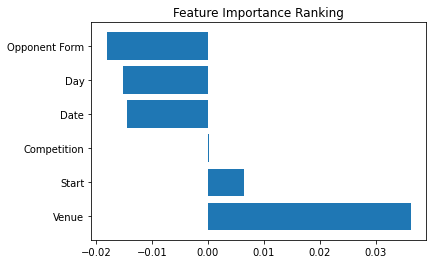

In [58]:
#Identify most important predictors
prednames=predictors.columns.tolist()
coefs=lr_model.coef_.tolist()[0]

important_feature_dict=dict(zip(prednames,coefs))
important_feature_dict=dict(sorted(important_feature_dict.items(), key=lambda item:item[1], reverse=True))

features=list(important_feature_dict.keys())
values=list(important_feature_dict.values())

plt.barh(features,values)
plt.title("Feature Importance Ranking")

## Part 6: Additional Data Analysis

### Messi Goals First 5 Years

In [62]:
messi_df=pd.read_excel("C:/Users/rprat/OneDrive/Documents/Messi Career Stats.xlsx")

In [63]:
messi_df["Score?"]=np.where(messi_df["Gls"]>0, "Scored", "Didn't Score")

In [64]:
games_goal=len(messi_df[(messi_df["Score?"]=="Scored")])
games_nogoal=len(messi_df[(messi_df["Score?"]=="Didn't Score")])

print(f"Messi scored in {round((games_goal/(games_nogoal+games_goal))*100)}% of the games he played in in the first 5 years of his career.")

Messi scored in 39% of the games he played in in the first 5 years of his career.


### Ronaldo Goals First 5 Years

In [65]:
ronaldo_df=pd.read_excel("C:/Users/rprat/OneDrive/Documents/Ronaldo Career Stats.xlsx")

In [66]:
ronaldo_df["Score?"]=np.where(ronaldo_df["Gls"]>0, "Scored", "Didn't Score")

In [67]:
games_goal=len(ronaldo_df[(ronaldo_df["Score?"]=="Scored")])
games_nogoal=len(ronaldo_df[(ronaldo_df["Score?"]=="Didn't Score")])

print(f"Ronaldo scored in {round((games_goal/(games_nogoal+games_goal))*100)}% of the games he played in in the first 5 years of his career.")

Ronaldo scored in 20% of the games he played in in the first 5 years of his career.
